# 6: Writing your own scan reader

PATATO uses the base class `ScanReader` to implement interfaces to many different data sources. To implement your own follow this guide.

Firstly, we will make some silly example data to demonstrate the principle.

In [1]:
import numpy as np
import os
import json
import glob
import patato as pat
from patato.io.hdf.fileimporter import ReaderInterface

In [2]:
class DemoReader(ReaderInterface):
    def __init__(self, file):
        """
        Can pass in the metadata.json file, or the Scan_1 folder.
        """
        
        pat.io.hdf.hdf5_interface.ReaderInterface.__init__(self)
        if file[-5:] == ".json":
            self.folder = os.path.split(file)
        else:
            self.folder = file
        with open(os.path.join(self.folder, "metadata.json"), "r") as metadata:
            self.metadata = json.load(metadata)
    
    
    def _get_rois(self):
        # Implement if desired. Should return a dictionary of recon name -> ROI type.
        # output = {}
        # output[("tumour_left", "0")] = pat.ROI(...) 
        return {}

    def get_scan_datetime(self):
        return self.metadata["DATETIME"]

    def _get_pa_data(self): # This is the time series data and attributes
        return np.load(os.path.join(self.folder, "ts.npz"))["time_series"], {'fs': self.get_sampling_frequency(), 
                                                                             'speedofsound': self.get_speed_of_sound()}

    def get_scan_name(self):
        return self.metadata["NAME"]

    def _get_temperature(self):
        return None # Save temperature if needed.

    def _get_correction_factor(self):
        return None # Save a correction factor if desired.

    def _get_scanner_z_position(self):
        return None # Save a z position if desired. 

    def _get_run_numbers(self):
        return self.metadata["RUN"] # Save run numbers if desired.

    def _get_repetition_numbers(self):
        return None # Save repetition numbers if desired.

    def _get_scan_times(self):
        return None # Save scan times if desired.

    def _get_sensor_geometry(self):
        return np.array(self.metadata["GEOMETRY"])

    def get_us_data(self):
        # This allows you to load in ultrasound data as well as your reconstructions. (not really supported in PATATO at the moment)
        return None, None

    def get_us_offsets(self):
        return None

    def get_impulse_response(self):
        return np.array(self.metadata["IRF"])

    def _get_wavelengths(self):
        return np.array(self.metadata["WAVELENGTHS"])

    def _get_water_absorption(self):
        return None, None

    def _get_datasets(self):
        # Get things like unmixed, reconstructions etc.
        output = {}
        # Update this to support unmixed data etc. if desired.
        image_type = "recons"
        # print(f"Loading {image_type}")
        output[image_type] = {}
        images = []
        
        if os.path.exists(os.path.join(self.folder, image_type)):
            # Loop through all types of this image and add them to the list
            for recon_folder in glob.glob(os.path.join(self.folder, image_type, "*")):
                for recon_file in glob.glob(os.path.join(recon_folder, "*.npz")):
                    all_data = dict(np.load(recon_file))
                    recon_data = all_data["data"]
                    del all_data["data"] # leaving the attributes
                    fov = [all_data[f"RECONSTRUCTION_FIELD_OF_VIEW_{x}"][()] for x in "XYZ"]
                    print(recon_data.shape, all_data["wavelengths"],all_data,fov)
                    image = pat.Reconstruction(recon_data, all_data["wavelengths"],
                                       attributes=all_data,
                                       field_of_view=fov)
                    recon_type = os.path.split(recon_folder)[-1]
                    recon_number = os.path.split(recon_file)[-1][:-4]
                    images.append(((recon_type, recon_number), image))
        for (recon, num), data in images:
            output[image_type][(recon, num)] = data
        return output

    def get_scan_comment(self):
        return self.metadata["COMMENT"]

    def _get_sampling_frequency(self):
        return self.metadata["FS"]

    def get_speed_of_sound(self):
        return self.metadata["C"]

    def _get_segmentation(self):
        return None


In [3]:
def make_example_data(base_folder="Demo Loader/Scan_1"):
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)
        
    # 1. Make important meta data as a json file:
    irf = np.zeros((2030, ))
    irf[2030//2] = 1
    
    metadata = {"NAME": "Demo scan name",
                "COMMENT": "Scan comment",
                "DATETIME": "Scan datetime",
                "FS": 4e7, # Sampling frequency (Hz)
                "C": 1500, # Speed of sound (m/s)
                "WAVELENGTHS": [700, 750, 800],
                "IRF": list(irf),
                "GEOMETRY": [[0.04 * np.cos(theta), 0.04 * np.sin(theta), 0.] for theta in np.linspace(0, np.pi * 2, 256, endpoint=False)],
                "RUN": [[0, 0, 0], [1, 1, 1]] # The run number for each wavelength and frame.
               }
    with open(os.path.join(base_folder, "metadata.json"), "w") as out_file:
        json.dump(metadata, out_file)
    
    # 2. Make file for time series data.
    time_series = np.random.random((2, 3, 256, 2030))
    np.savez(os.path.join(base_folder, "ts"), time_series=time_series)
    
    # 3. Make folder for reconstructions:
    recon_folder = os.path.join(base_folder, "recons")
    if not os.path.exists(recon_folder):
        os.mkdir(recon_folder)
        
    def add_reconstruction(recon_folder, data, recon_name, settings):
        group_folder = os.path.join(recon_folder, recon_name)
        if not os.path.exists(group_folder):
            os.mkdir(group_folder)
        
        # Make a new folder for the new reconstruction.
        def scan_number(x):
            x = os.path.split(x)[-1]
            try:
                return int(x) 
            except ValueError:
                return 0
            
        # Make a folder for the new reconstructed image. This allows for saving e.g. multiple versions of a backprojection.
        existing_recons = glob.glob(os.path.join(group_folder, "*.npz"))
        reconstruction_number = str(max(map(scan_number, existing_recons)) + 1 if existing_recons else 0) + ".npz"
        
        recon_file = os.path.join(group_folder, f"{reconstruction_number}")
        return np.savez(recon_file, data=data, **settings)
    
    add_reconstruction(recon_folder, np.random.random((2, 3, 1, 333, 333)), "Reference Backprojection", 
                       {'ENVELOPE_DETECTION': False,
                        'FILTER_HIGH_PASS': 5000.0,
                        'FILTER_LOW_PASS': 7000000.0,
                        'HILBERT_TRANSFORM': True,
                        'INTERPOLATE_DETECTORS': 2,
                        'INTERPOLATE_TIME': 3,
                        'IRF': True,
                        'PREPROCESSING_ALGORITHM': 'Standard Preprocessor',
                        'RECONSTRUCTION_ALGORITHM': 'Reference Backprojection',
                        'RECONSTRUCTION_FIELD_OF_VIEW_X': 0.024975,
                        'RECONSTRUCTION_FIELD_OF_VIEW_Y': 0.024975,
                        'RECONSTRUCTION_FIELD_OF_VIEW_Z': 0.0,
                        'RECONSTRUCTION_NX': 333,
                        'RECONSTRUCTION_NY': 333,
                        'RECONSTRUCTION_NZ': 1,
                        'UniversalBackProjection': False,
                        'WINDOW_SIZE': 'hann',
                        'speedofsound': 1500,
                        'wavelengths': np.array([700., 750., 800.])})
make_example_data()

In [4]:
pa = pat.PAData(DemoReader("Demo Loader/Scan_1"))

(2, 3, 1, 333, 333) [700. 750. 800.] {'ENVELOPE_DETECTION': array(False), 'FILTER_HIGH_PASS': array(5000.), 'FILTER_LOW_PASS': array(7000000.), 'HILBERT_TRANSFORM': array(True), 'INTERPOLATE_DETECTORS': array(2), 'INTERPOLATE_TIME': array(3), 'IRF': array(True), 'PREPROCESSING_ALGORITHM': array('Standard Preprocessor', dtype='<U21'), 'RECONSTRUCTION_ALGORITHM': array('Reference Backprojection', dtype='<U24'), 'RECONSTRUCTION_FIELD_OF_VIEW_X': array(0.024975), 'RECONSTRUCTION_FIELD_OF_VIEW_Y': array(0.024975), 'RECONSTRUCTION_FIELD_OF_VIEW_Z': array(0.), 'RECONSTRUCTION_NX': array(333), 'RECONSTRUCTION_NY': array(333), 'RECONSTRUCTION_NZ': array(1), 'UniversalBackProjection': array(False), 'WINDOW_SIZE': array('hann', dtype='<U4'), 'speedofsound': array(1500), 'wavelengths': array([700., 750., 800.])} [0.024975, 0.024975, 0.0]
(2, 3, 1, 333, 333) [700. 750. 800.] {'ENVELOPE_DETECTION': array(False), 'FILTER_HIGH_PASS': array(5000.), 'FILTER_LOW_PASS': array(7000000.), 'HILBERT_TRANSFORM

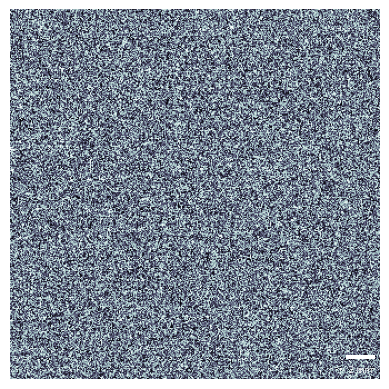

In [5]:
pa.set_default_recon()
pa.get_scan_reconstructions().imshow()